<a href="https://colab.research.google.com/github/Andyqballer/Home-Work-7/blob/main/HomeWork7Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 170M/170M [00:06<00:00, 26.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [10/200], Loss: 0.1203, Test Accuracy: 75.12%
Epoch [20/200], Loss: 0.0625, Test Accuracy: 75.22%
Epoch [30/200], Loss: 0.0483, Test Accuracy: 74.75%
Epoch [40/200], Loss: 0.0423, Test Accuracy: 73.78%
Epoch [50/200], Loss: 0.0439, Test Accuracy: 74.16%
Epoch [60/200], Loss: 0.0453, Test Accuracy: 73.93%
Epoch [70/200], Loss: 0.0363, Test Accuracy: 74.30%
Epoch [80/200], Loss: 0.0463, Test Accuracy: 74.80%
Epoch [90/200], Loss: 0.0418, Test Accuracy: 74.63%
Epoch [100/200], Loss: 0.0419, Test Accuracy: 74.79%
Epoch [110/200], Loss: 0.0422, Test Accuracy: 74.30%
Epoch [120/200], Loss: 0.0537, Test Accuracy: 73.81%
Epoch [130/200], Loss: 0.0552, Test Accuracy: 74.55%
Epoch [140/200], Loss: 0.0382, Test Accuracy: 73.85%
Epoch [150/200], Loss: 0.0451, Test Accuracy: 74.10%
Epoch [160/200], Loss: 0.0364, Test Accuracy: 74.16%
Epoch [170/200], Loss: 0.0513, Test Accuracy: 73.45%
Epoch [180/200], Lo

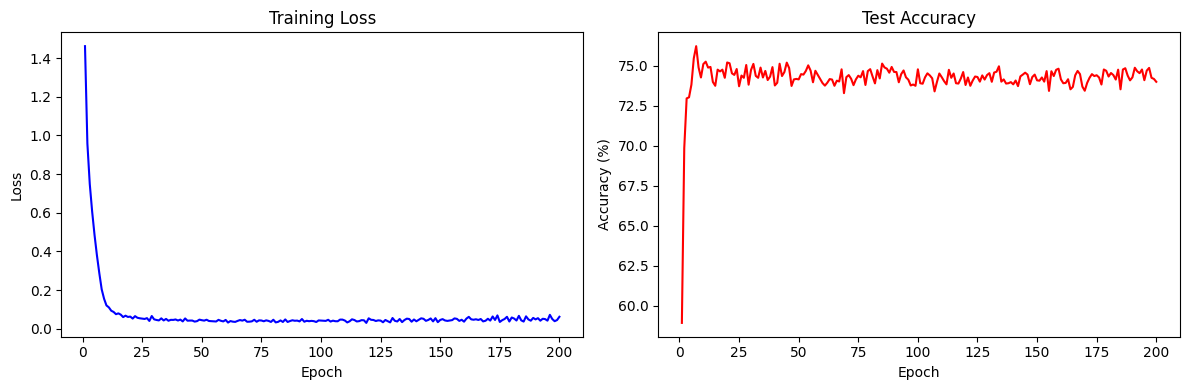

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 200
batch_size = 64
learning_rate = 0.001

# CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                        shuffle=False)

# Extended CNN Model
class ExtendedCNN(nn.Module):
    def __init__(self):
        super(ExtendedCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            # First conv layer
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second conv layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Additional conv layer
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.fc_layer = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Added dropout to prevent overfitting
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    model.train()
    total_step = len(train_loader)
    train_time = 0
    train_losses = []
    test_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Evaluate on test set
        test_accuracy = evaluate_model(model, test_loader)
        test_accuracies.append(test_accuracy)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    train_time = time.time() - start_time
    return train_time, train_losses, test_accuracies

def evaluate_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def plot_training_progress(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, 'r-')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

# Initialize the model
model = ExtendedCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
train_time, train_losses, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader, criterion, optimizer, num_epochs)

# Calculate model size
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

model_size = count_parameters(model)

print(f'\nTraining Time: {train_time:.2f} seconds')
print(f'Final Training Loss: {train_losses[-1]:.4f}')
print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')
print(f'Model Size: {model_size:,} parameters')

# Plot training progress
plot_training_progress(train_losses, test_accuracies)